In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, spearmanr
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity, cosine_distances

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')

df = pd.read_csv('/content/drive/MyDrive/datasets/CustomerSegmentation/Train.csv')
df_original = df.copy()


**STEP 1:** DATA ACQUISITION & UNDERSTANDING

In [3]:
print("\nDataset Shape:", df.shape)
print("\nFirst Few Rows:")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nBasic Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())



Dataset Shape: (8068, 11)

First Few Rows:
       ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0  462809    Male           No   22        No     Healthcare              1.0   
1  462643  Female          Yes   38       Yes       Engineer              NaN   
2  466315  Female          Yes   67       Yes       Engineer              1.0   
3  461735    Male          Yes   67       Yes         Lawyer              0.0   
4  462669  Female          Yes   40       Yes  Entertainment              NaN   

  Spending_Score  Family_Size  Var_1 Segmentation  
0            Low          4.0  Cat_4            D  
1        Average          3.0  Cat_4            A  
2            Low          1.0  Cat_6            B  
3           High          2.0  Cat_6            B  
4           High          6.0  Cat_6            A  

Data Types:
ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Professio


Statistical Measures:

Age:
  Mean: 43.4669
  Median: 40.0000
  Mode: [35]
  Variance: 279.2808
  Std Dev: 16.7117
  Skewness: 0.6960

Work_Experience:
  Mean: 2.6417
  Median: 1.0000
  Mode: [1.]
  Variance: 11.6060
  Std Dev: 3.4068
  Skewness: 1.3062

Family_Size:
  Mean: 2.8501
  Median: 3.0000
  Mode: [2.]
  Variance: 2.3452
  Std Dev: 1.5314
  Skewness: 1.0108


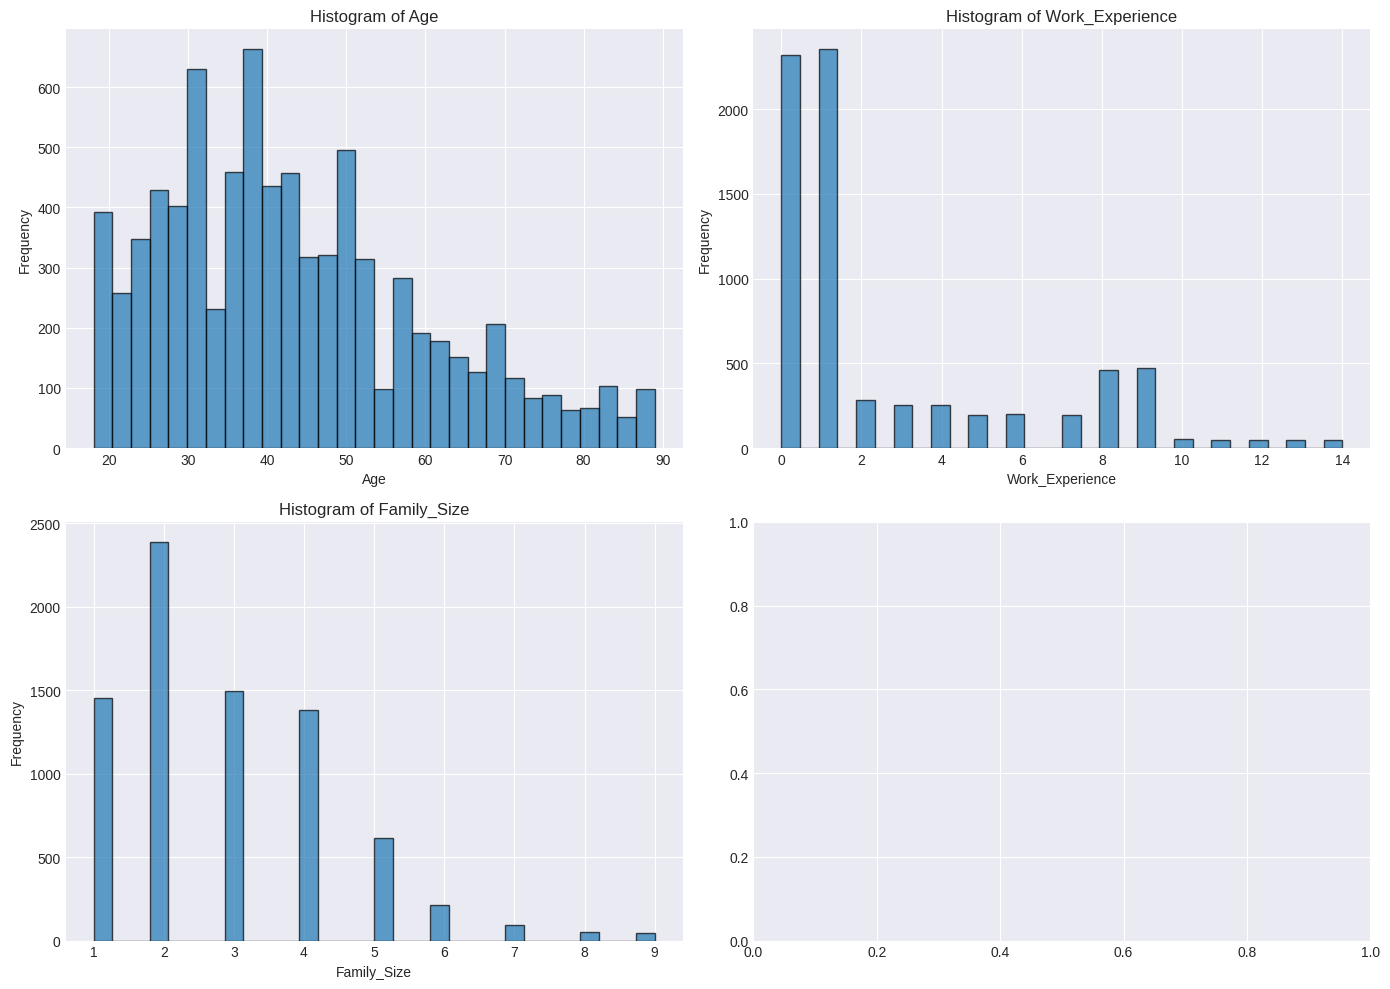

In [4]:
df = df.drop("ID",axis=1)
print("\nStatistical Measures:")
for col in df.select_dtypes(include=[np.number]).columns:
    print(f"\n{col}:")
    print(f"  Mean: {df[col].mean():.4f}")
    print(f"  Median: {df[col].median():.4f}")
    print(f"  Mode: {df[col].mode().values}")
    print(f"  Variance: {df[col].var():.4f}")
    print(f"  Std Dev: {df[col].std():.4f}")
    print(f"  Skewness: {df[col].skew():.4f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
numeric_cols = df.select_dtypes(include=[np.number]).columns
for i, col in enumerate(list(numeric_cols)[:4]):
    ax = axes[i // 2, i % 2]
    ax.hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('01_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

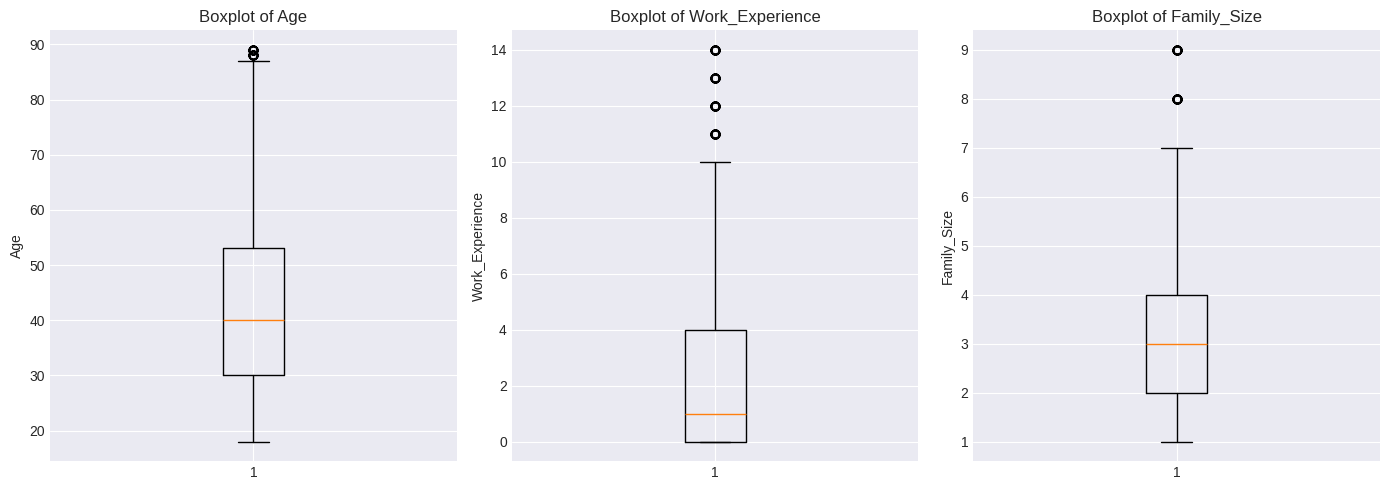

In [5]:
fig, axes = plt.subplots(1, min(4, len(numeric_cols)), figsize=(14, 5))
if min(4, len(numeric_cols)) == 1:
    axes = [axes]
for i, col in enumerate(list(numeric_cols)[:4]):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.savefig('02_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

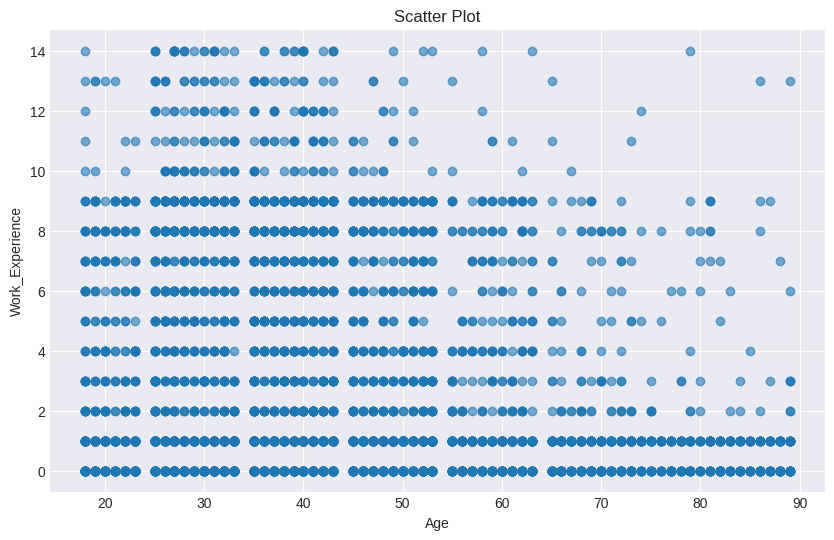

In [6]:
numeric_data = df.select_dtypes(include=[np.number])
if len(numeric_data.columns) >= 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(numeric_data.iloc[:, 0], numeric_data.iloc[:, 1], alpha=0.6)
    plt.xlabel(numeric_data.columns[0])
    plt.ylabel(numeric_data.columns[1])
    plt.title('Scatter Plot')
    plt.savefig('03_scatter_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
categorical_cols = df.select_dtypes(include=['object']).columns
if len(categorical_cols) >= 2:
    cat1, cat2 = categorical_cols[0], categorical_cols[1]
    contingency_table = pd.crosstab(df[cat1], df[cat2])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"\n\nChi-Square Test Results ({cat1} vs {cat2}):")
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Degrees of Freedom: {dof}")



Chi-Square Test Results (Gender vs Ever_Married):
Chi-Square Statistic: 106.4551
P-value: 0.0000
Degrees of Freedom: 1




Pearson Correlation Matrix:
                      Age  Work_Experience  Family_Size
Age              1.000000        -0.190789    -0.280517
Work_Experience -0.190789         1.000000    -0.063234
Family_Size     -0.280517        -0.063234     1.000000


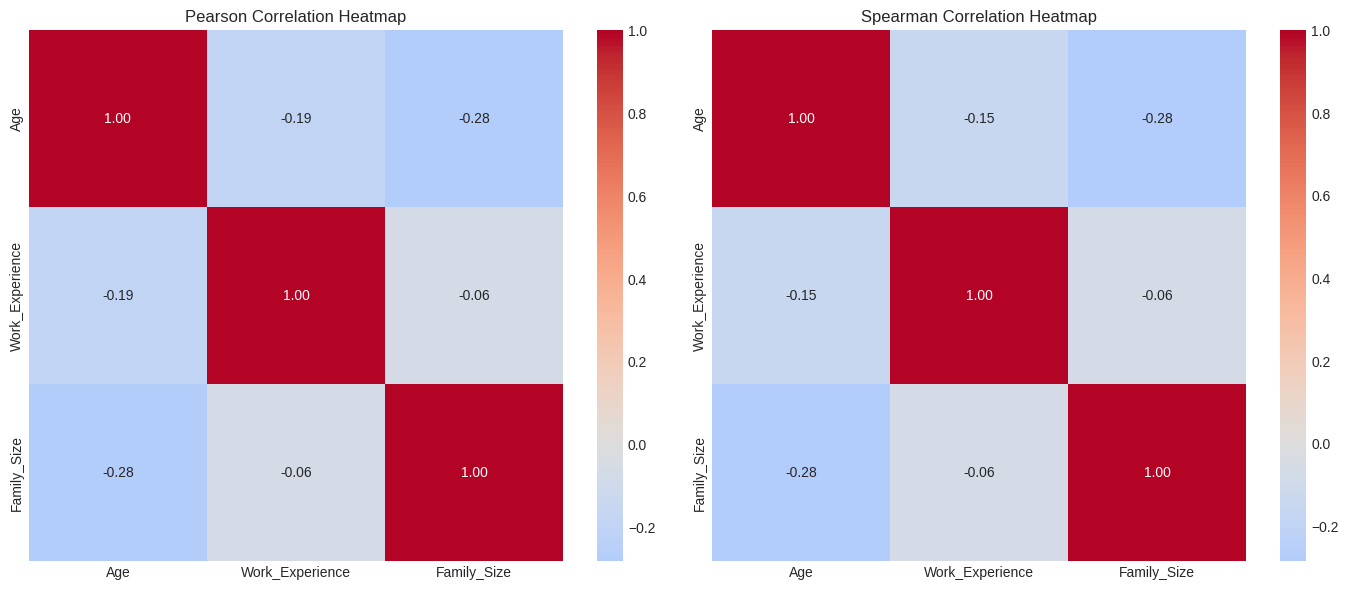

In [8]:
correlation_pearson = numeric_data.corr(method='pearson')
correlation_spearman = numeric_data.corr(method='spearman')

print("\n\nPearson Correlation Matrix:")
print(correlation_pearson)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(correlation_pearson, annot=True, cmap='coolwarm', center=0, ax=axes[0], fmt='.2f')
axes[0].set_title('Pearson Correlation Heatmap')
sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', center=0, ax=axes[1], fmt='.2f')
axes[1].set_title('Spearman Correlation Heatmap')
plt.tight_layout()
plt.savefig('04_correlation_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

**STEP 2:** DATA QUALITY AND CLEANING


Missing Values Before Cleaning:
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64


Missing Values After Cleaning:
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64


/tmp/ipython-input-3850991366.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


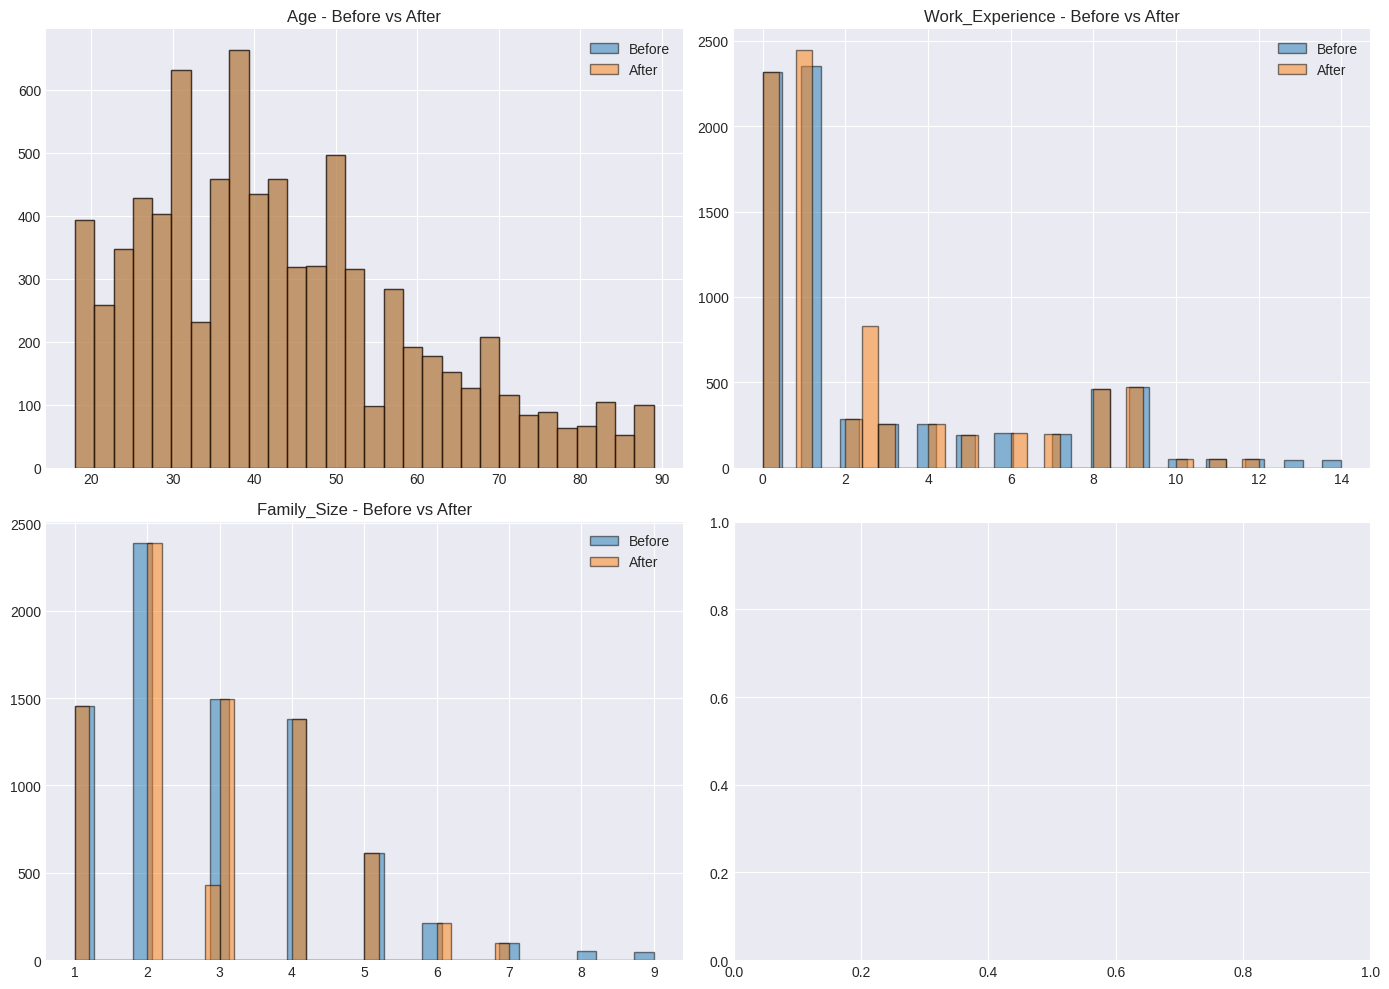

In [9]:
print("\nMissing Values Before Cleaning:")
print(df.isnull().sum())

numeric_cols_list = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols_list:
    if df[col].isnull().sum() > 0:
        imputer_mean = SimpleImputer(strategy='mean')
        df[col] = imputer_mean.fit_transform(df[[col]])[:, 0]

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

Q1 = df[numeric_cols_list].quantile(0.25)
Q3 = df[numeric_cols_list].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for col in numeric_cols_list:
    mean_val = df[col].mean()
    std_val = df[col].std()
    outlier_indices = np.abs((df[col] - mean_val) / std_val) > 3
    if outlier_indices.sum() > 0:
        median_val = df[col].median()
        df.loc[outlier_indices, col] = median_val

print("\n\nMissing Values After Cleaning:")
print(df.isnull().sum())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, col in enumerate(list(numeric_cols_list)[:4]):
    ax = axes[i // 2, i % 2]
    ax.hist(df_original[col].dropna(), bins=30, alpha=0.5, label='Before', edgecolor='black')
    ax.hist(df[col].dropna(), bins=30, alpha=0.5, label='After', edgecolor='black')
    ax.set_title(f'{col} - Before vs After')
    ax.legend()
plt.tight_layout()
plt.savefig('05_cleaning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

**STEP 3:** DATA TRANSFORMATION


Equal-Width Binning (Age):
Age_equal_width
Very Low     2461
Low          2565
Medium       1705
High          864
Very High     473
Name: count, dtype: int64


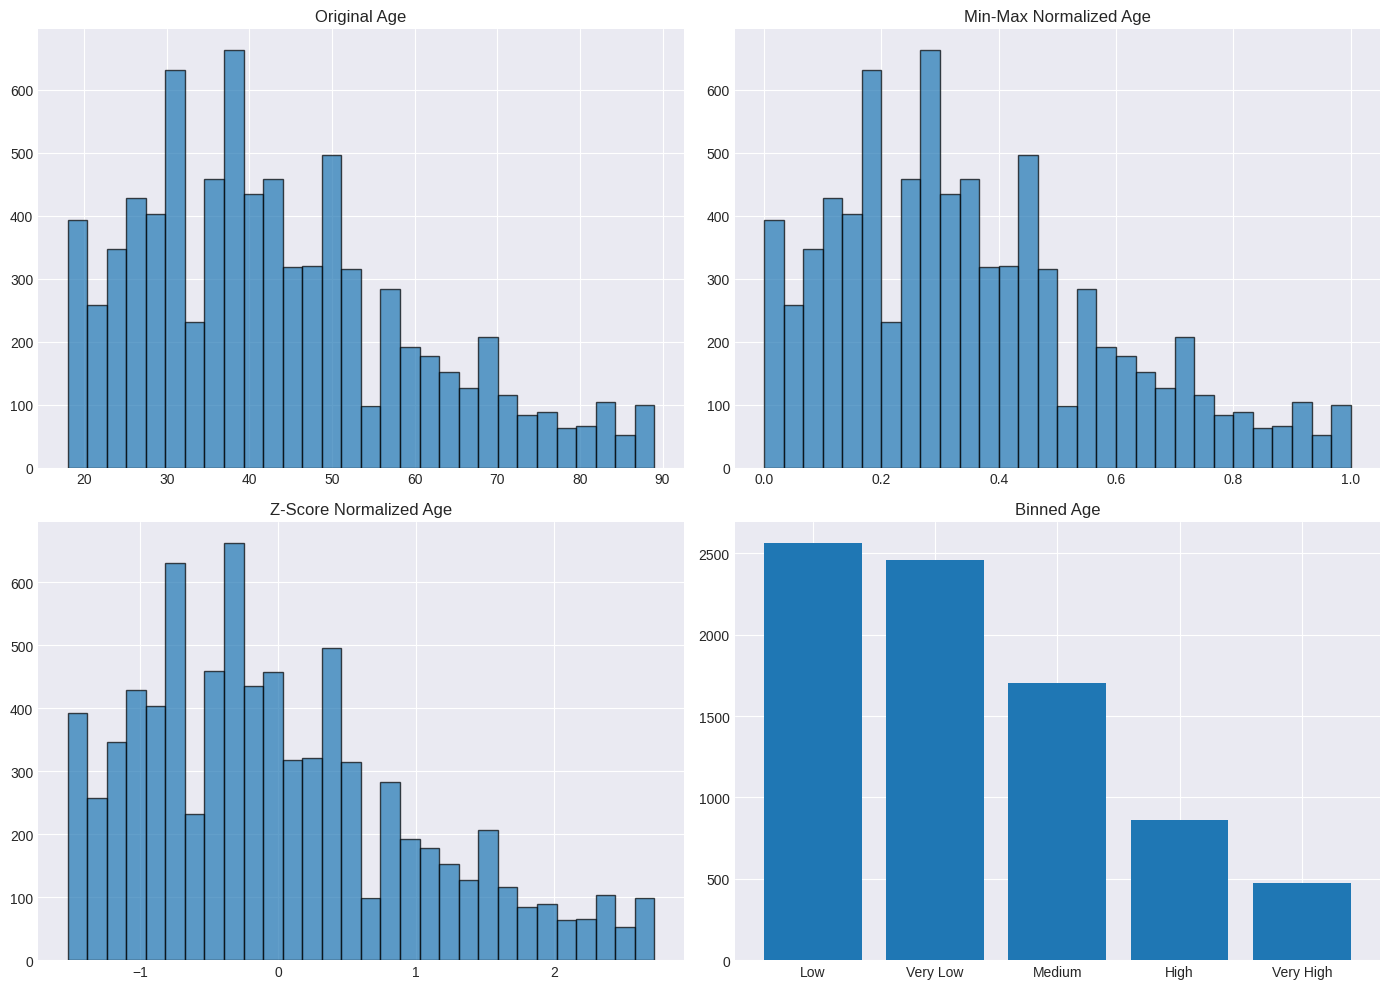

In [10]:
df_transformed = df.copy()

minmax_scaler = MinMaxScaler(feature_range=(0, 1))
df_minmax = pd.DataFrame(minmax_scaler.fit_transform(df_transformed[numeric_cols_list]),
                         columns=[f'{col}_minmax' for col in numeric_cols_list])

zscore_scaler = StandardScaler()
df_zscore = pd.DataFrame(zscore_scaler.fit_transform(df_transformed[numeric_cols_list]),
                         columns=[f'{col}_zscore' for col in numeric_cols_list])

df_transformed = pd.concat([df_transformed, df_minmax, df_zscore], axis=1)

numeric_col_for_binning = numeric_cols_list[0]
df_transformed[f'{numeric_col_for_binning}_equal_width'] = pd.cut(
    df_transformed[numeric_col_for_binning], bins=5,
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

print(f"\nEqual-Width Binning ({numeric_col_for_binning}):")
print(df_transformed[f'{numeric_col_for_binning}_equal_width'].value_counts().sort_index())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
col = numeric_cols_list[0]
axes[0, 0].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title(f'Original {col}')
axes[0, 1].hist(df_minmax[f'{col}_minmax'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title(f'Min-Max Normalized {col}')
axes[1, 0].hist(df_zscore[f'{col}_zscore'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title(f'Z-Score Normalized {col}')
axes[1, 1].bar(df_transformed[f'{numeric_col_for_binning}_equal_width'].value_counts().index,
               df_transformed[f'{numeric_col_for_binning}_equal_width'].value_counts().values)
axes[1, 1].set_title(f'Binned {numeric_col_for_binning}')
plt.tight_layout()
plt.savefig('06_transformation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

**STEP 4:** DATA REDUCTION - PCA


Explained Variance Ratio by Component:
PC1: 0.4334 (0.4334 cumulative)
PC2: 0.3488 (0.7822 cumulative)
PC3: 0.2178 (1.0000 cumulative)

Original features: 3
Reduced features: 3
Variance retained: 1.0000


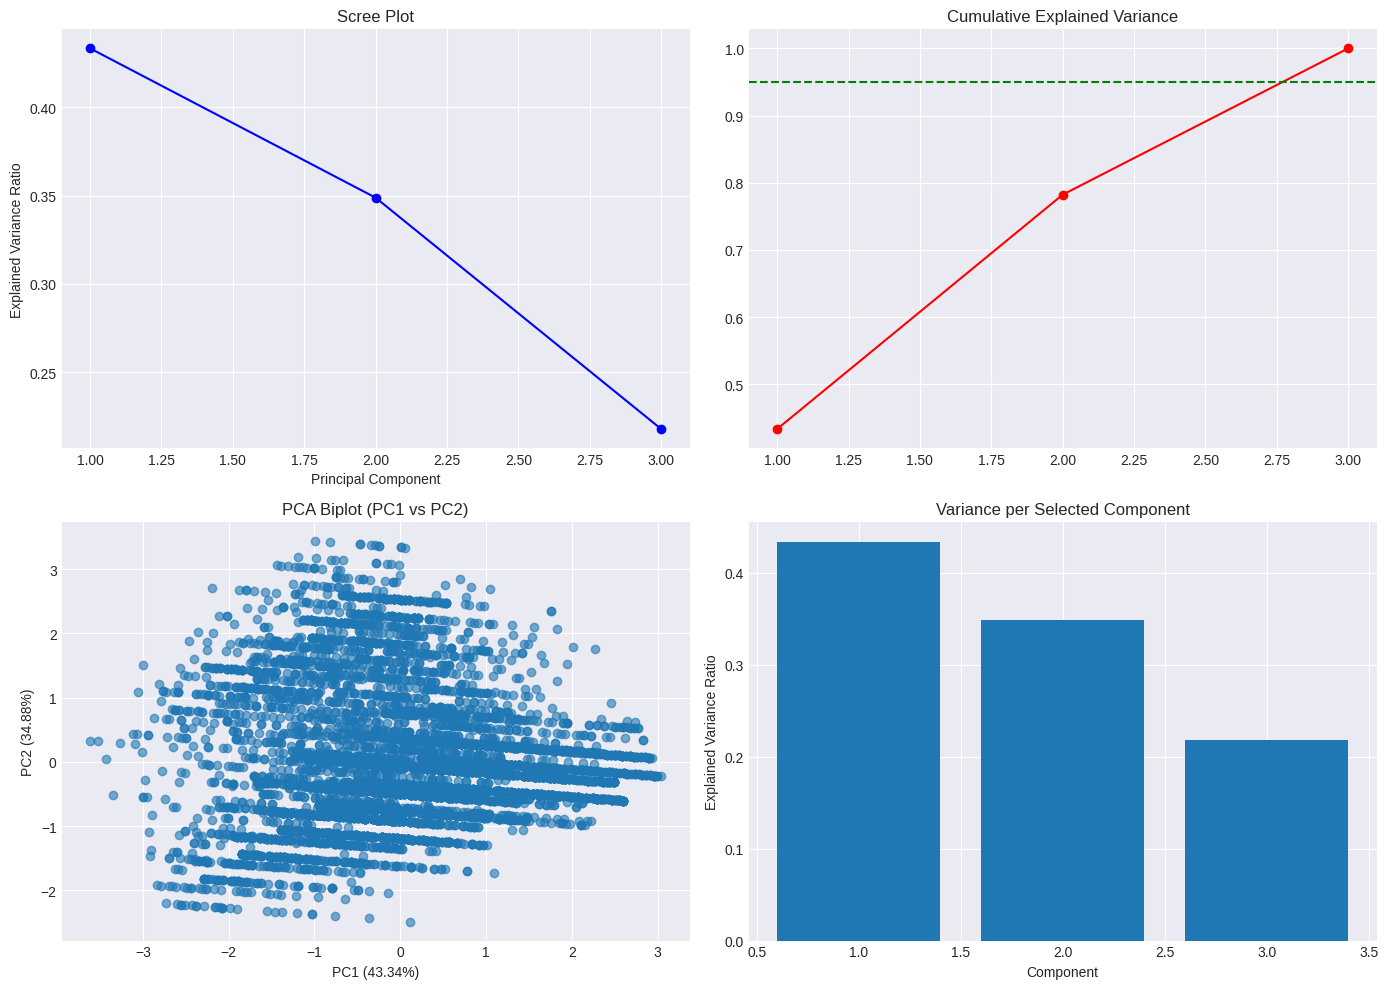

In [11]:
original_numeric_cols = [col for col in numeric_cols_list if not any(x in col for x in ['_minmax', '_zscore'])]
X = df_transformed[original_numeric_cols].copy()

scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)

pca_full = PCA()
pca_full.fit(X_scaled)

explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("\nExplained Variance Ratio by Component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"\nOriginal features: {X.shape[1]}")
print(f"Reduced features: {X_pca.shape[1]}")
print(f"Variance retained: {pca.explained_variance_ratio_.sum():.4f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
axes[0, 0].set_title('Scree Plot')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')

axes[0, 1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
axes[0, 1].axhline(y=0.95, color='g', linestyle='--')
axes[0, 1].set_title('Cumulative Explained Variance')

if X_pca.shape[1] >= 2:
    axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
    axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    axes[1, 0].set_title('PCA Biplot (PC1 vs PC2)')

axes[1, 1].bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
axes[1, 1].set_title('Variance per Selected Component')
axes[1, 1].set_xlabel('Component')
axes[1, 1].set_ylabel('Explained Variance Ratio')

plt.tight_layout()
plt.savefig('07_pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


**STEP 5:** DISTANCE & SIMILARITY MEASURES


Euclidean Distance - Min: 0.0598, Max: 5.2744
Manhattan Distance - Min: 0.0598, Max: 8.7205
Cosine Similarity - Min: -0.9993, Max: 1.0000
Cosine Distance - Min: 0.0000, Max: 1.9993


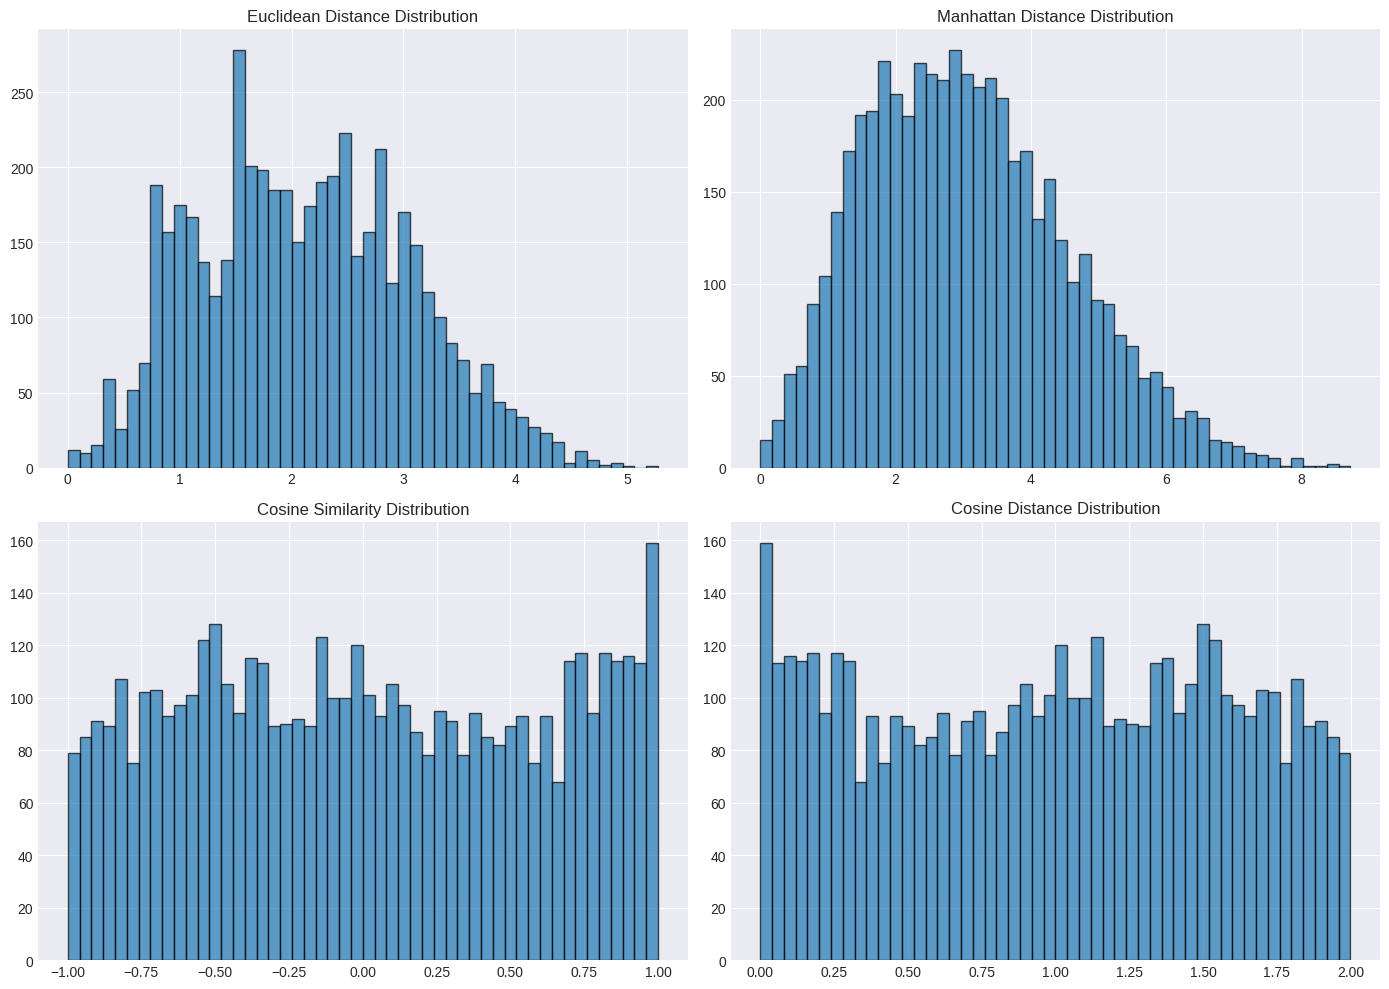

In [12]:
sample_size = min(100, len(X_scaled))
X_sample = X_scaled[:sample_size]

euclidean_dist = euclidean_distances(X_sample)
manhattan_dist = manhattan_distances(X_sample)
cosine_sim = cosine_similarity(X_sample)
cosine_dist = cosine_distances(X_sample)

print(f"\nEuclidean Distance - Min: {euclidean_dist[euclidean_dist > 0].min():.4f}, Max: {euclidean_dist.max():.4f}")
print(f"Manhattan Distance - Min: {manhattan_dist[manhattan_dist > 0].min():.4f}, Max: {manhattan_dist.max():.4f}")
print(f"Cosine Similarity - Min: {cosine_sim[cosine_sim < 1].min():.4f}, Max: {cosine_sim.max():.4f}")
print(f"Cosine Distance - Min: {cosine_dist[cosine_dist > 0].min():.4f}, Max: {cosine_dist.max():.4f}")

euclidean_flat = euclidean_dist[np.triu_indices_from(euclidean_dist, k=1)]
manhattan_flat = manhattan_dist[np.triu_indices_from(manhattan_dist, k=1)]
cosine_sim_flat = cosine_sim[np.triu_indices_from(cosine_sim, k=1)]
cosine_dist_flat = cosine_dist[np.triu_indices_from(cosine_dist, k=1)]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].hist(euclidean_flat, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Euclidean Distance Distribution')
axes[0, 1].hist(manhattan_flat, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Manhattan Distance Distribution')
axes[1, 0].hist(cosine_sim_flat, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Cosine Similarity Distribution')
axes[1, 1].hist(cosine_dist_flat, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Cosine Distance Distribution')
plt.tight_layout()
plt.savefig('08_distance_similarity_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
